# フィラデルフィア半導体指数

In [2]:
import sys
import os

import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

try:
    __file__
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
except NameError:
    from pathlib import Path
    Path().resolve()
    sys.path.append(os.path.join(Path().resolve(), '..'))

from funcs.technical import psar

In [3]:
symbol = '^SOX'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-09-05 00:00:00-04:00,4708.589844,4821.640137,4698.049805,4742.419922,0,0.0,0.0
2024-09-06 00:00:00-04:00,4698.779785,4701.089844,4507.680176,4528.220215,0,0.0,0.0
2024-09-09 00:00:00-04:00,4598.279785,4636.620117,4547.180176,4625.779785,0,0.0,0.0
2024-09-10 00:00:00-04:00,4624.990234,4684.589844,4561.930176,4680.669922,0,0.0,0.0
2024-09-11 00:00:00-04:00,4712.129883,4918.919922,4616.589844,4910.169922,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-26 00:00:00-05:00,4959.970215,5032.640137,4935.330078,4990.819824,0,0.0,0.0
2025-02-27 00:00:00-05:00,5032.879883,5041.149902,4684.779785,4686.750000,0,0.0,0.0
2025-02-28 00:00:00-05:00,4684.220215,4795.890137,4634.950195,4766.750000,0,0.0,0.0


## 日足チャートとパラボリック SAR

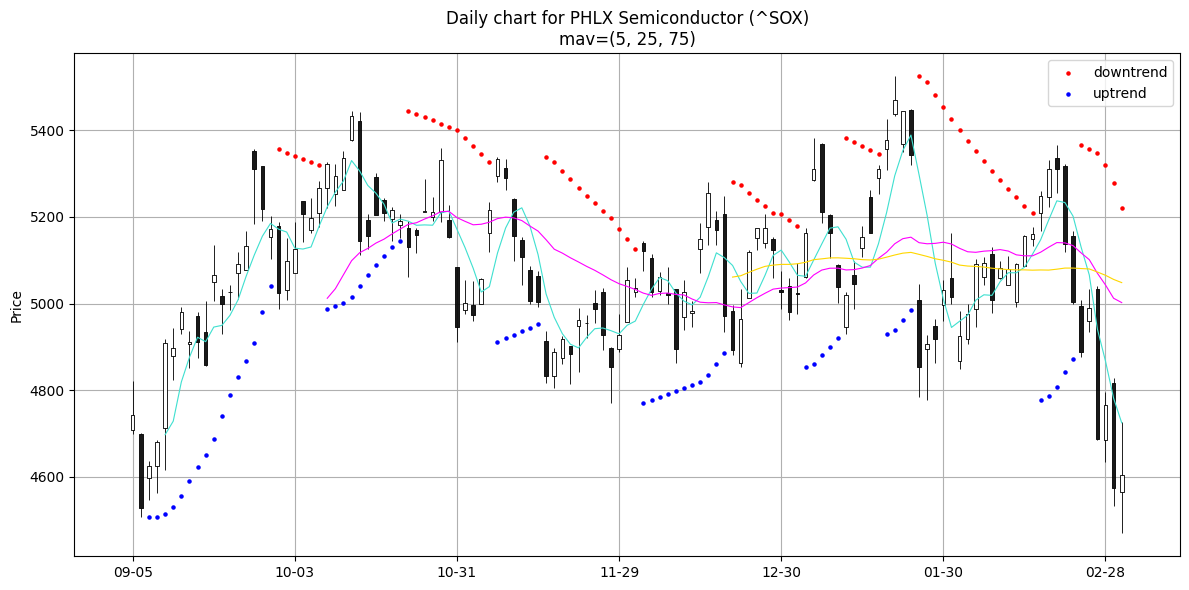

In [4]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()

plt.tight_layout()
plt.savefig('daily_chart_SOX.png')
plt.show()

In [4]:
df.tail(2)['Close']

Date
2024-11-11 00:00:00-05:00    5156.390137
2024-11-12 00:00:00-05:00    5095.285156
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2024-11-11 00:00:00-05:00         NaN
2024-11-12 00:00:00-05:00   -61.10498
Name: Close, dtype: float64